In [1]:
import pypsa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.dates as mdates
from datetime import datetime
from datetime import date
from cProfile import label
from pypsa.linopf import *
from pypsa.linopt import *
from pandas import DataFrame

from pyomo.environ import Constraint


%matplotlib inline
plt.rc("figure", figsize=(8, 8))

Text(0.5, 0, 'Time Stamp')

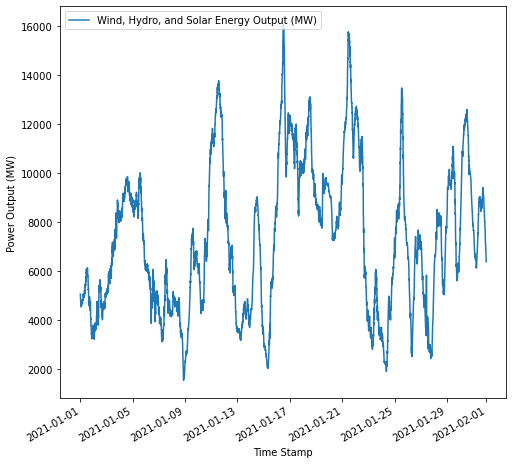

In [2]:

df = pd.read_csv (r'/home/jason/storage-diss/gridwatch.csv', index_col=1, parse_dates=True ) #year of 2021
del df['id']
#df.plot()
df = df.sum(axis = 1)
df['2021-1-01':'2021-1-31'].plot(label='Wind, Hydro, and Solar Energy Output (MW)')
plt.legend(loc="upper left")
plt.ylabel('Power Output (MW)')
plt.xlabel('Time Stamp')

In [3]:
network = pypsa.Network()

In [4]:
network.snapshots = i = pd.date_range("2021-01-01 00:00", "2021-01-31 23:00", freq="6H")#0.2499H

In [5]:
network.add('Bus',"London", v_nom=380)
network.add("Bus", "Battery", carrier="AC")

In [6]:
#Demand
network.add(
  "Load",
  name= 'LondonDemand',
  bus='London',
  p_set= [3000]*len(network.snapshots) #MW active power set point
)

In [7]:
df = pd.read_csv (r'/home/jason/storage-diss/gridwatch.csv', index_col=1, parse_dates=True ) #year of 2021
del df['id']
#df.plot()
df = df.sum(axis = 1)
resample = df.resample('6H')#15min
#HourlyData = resample.df
HourlyData = resample.mean()

network.add(
    'Generator',
    name= 'TotalGenerator',
    bus= 'London',
    p_nom= 19435.583333333332, #MW nominal power
    p_max_pu= HourlyData["2021-01-01 00:00": "2021-01-31 23:24"].values / HourlyData["2021-01-01 00:00": "2021-01-31 23:24"].values.max(),
    capital_cost= 1893000, #currency/MWh
    efficiency=1,
    marginal_cost=95, #currency/MWh
    carrier='AC'
    )

In [8]:
#network.add("Link", "Battery", carrier="AC")


#Generation to battery storage, Cable
network.add(
  "Link",
  "InvertertoStore",
  bus0="London",
  bus1="Battery",
  capital_cost=205500,
  p_nom_extendable=True,
  efficiency=0.9,
)

#Elect to London, Li ion
network.add(
  "Link",
  "InvertertoDemand",
  bus0="Battery",
  bus1="London",
  capital_cost=205500,
  p_nom_extendable=True,
  efficiency=0.9,
)

#Storage
network.add(
  "Store",
  "Battery",
  bus="Battery",
  capital_cost=192000,
  marginal_cost=3.1,
  e_nom_extendable=True,
  e_cyclic=True,
)

In [9]:
def extra_functionality(network, snapshots):
    model = network.model
    model.link_fix = Constraint(
        rule=lambda model: model.link_p_nom["InvertertoStore"]
        == model.link_p_nom["InvertertoDemand"]
    )

In [10]:
network.lopf(extra_functionality=extra_functionality)

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 35340000.0
  Upper bound: 35340000.0
  Number of objectives: 1
  Number of constraints: 1118
  Number of variables: 624
  Number of nonzeros: 2235
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.2438821792602539
# ----------------------------------------------------------
#   Solution Information
# --------------------

/home/jason/anaconda3/lib/python3.9/site-packages/pypsa/opf.py:1293: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat({c.name:


(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

In [11]:
network.objective *3

#When comapred to 1 hour data

106020000.0

In [12]:
network.objective * 36 /10**9

1.27224

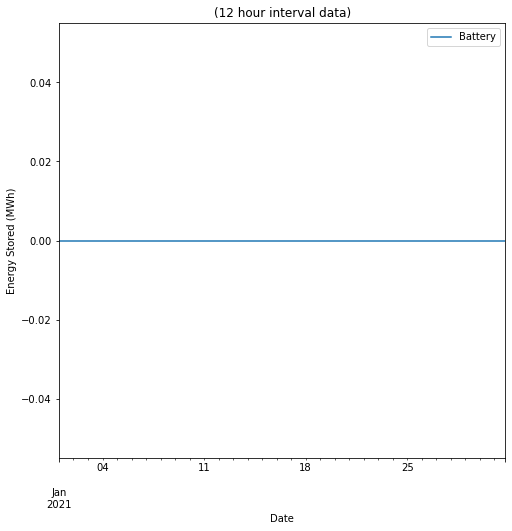

In [14]:
import matplotlib.pyplot as plt


network.stores_t.e.plot()
plt.xlabel("Date")
plt.ylabel("Energy Stored (MWh)")
plt.title("(12 hour interval data)")
plt.legend()


